# NLP Standard Project: Human Values Detection
Andrea Alfonsi, Gianluca Di Tuccio, Lorenzo Orsini<br><br>
In this project we performed the [Human Values Detection task for the SemEval 2023](https://touche.webis.de/semeval23/touche23-web/index.html). The original task is a multi-label classification problem with 20 categories.<br>
We used both a support vector machine (SVM) and a fine-tuned version of XLNet-large to perform the classification and obtained F1 scores of 0.31 and 0.49, respectively. In addition, we also performed the same task on a subset of the six most frequent classes (out of the original 20) using the same two models. XLNet-large obtained an F1 score of 0.62, while the SVM obtained an F1 score of 0.52.<br>
The results for the models with different seeds can be found at the end of each section. We tested the models with seeds 42, 2022, and 1337, and all the reported F1 scores were calculated over these seeds.<br>
This notebook is organized as follows:
- chapter 1: import of the useful libraries and the loading of the data;
- chapter 2: statistics of the data;
- chapter 3: 20-labels task for each model and results;
- chapter 4: 6-labels task for each model and results.
At the end, you can find all the links (datasets, codes, etc) used in this notebook.

In [ ]:
%%capture
!pip install transformers
!pip install datasets

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!git clone https://github.com/DitucSpa/Human-Values-Detection

Cloning into 'Human-Values-Detection'...
remote: Enumerating objects: 18, done.
remote: Counting objects: 100% (18/18), done.
remote: Compressing objects: 100% (16/16), done.
remote: Total 18 (delta 1), reused 14 (delta 0), pack-reused 0
Unpacking objects: 100% (18/18), done.


## 1. Import useful libraries and data

In [ ]:
# imports for the transformer model
from datasets import Dataset
from transformers import AdamW, Trainer, AutoTokenizer, XLNetForSequenceClassification, TrainingArguments
from transformers import get_cosine_schedule_with_warmup, EvalPrediction
import torch
from torch import nn

# imports for SVM
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.corpus import stopwords
import nltk
import pickle # used for saving/loading the models
from sklearn import svm
from sklearn.multiclass import OneVsRestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

# imports for other stuff and statistics
import matplotlib.pyplot as plt
import pandas as pd
import csv
import numpy as np
import os
import random
from statistics import mean
import logging
import re
import warnings
from tqdm import tqdm
import matplotlib.pyplot as plt
from IPython.display import Image
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score, classification_report
from collections import Counter
warnings.filterwarnings('ignore')

# disable all the useless outputs
def set_global_logging_level(level=logging.ERROR, prefices=[""]):
    prefix_re = re.compile(fr'^(?:{ "|".join(prefices) })')
    for name in logging.root.manager.loggerDict:
        if re.match(prefix_re, name):
            logging.getLogger(name).setLevel(level)
set_global_logging_level(logging.ERROR)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [ ]:
# set the seed for SVM and transformer
# NOTE: due to computational cost and time problems, we run the entire notebook with differents seeds (42, 2022, 1337).
# each time, we saved the models on our Drive directory.
# in the ***Results*** chapter at the end of each section (i.e. Task 20-labels and Task 6-labels)
def set_seed(number):
  torch.manual_seed(number)
  torch.cuda.manual_seed_all(number)
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = False
  np.random.seed(number)
  random.seed(number)
  os.environ['PYTHONHASHSEED'] = str(number)
seed=42
set_seed(seed)

In [ ]:
# load the datasets (train + val)
# in the test set the labels are not provided
path = 'Human-Values-Detection/datasets/'

def create_split(path, split):
  arguments = pd.read_csv(path + 'arguments-' + split + '.tsv', sep='\t')
  labels = pd.read_csv(path + 'labels-' + split + '.tsv', sep='\t')
  return pd.merge(arguments, labels, on='Argument ID')

train = create_split(path, 'training')
val = create_split(path, 'validation')

In [ ]:
print(train.shape, val.shape) # statistiche sulla shape
train.head()

(5393, 24) (1896, 24)


,Argument ID,Conclusion,Stance,Premise,Self-direction: thought,Self-direction: action,Stimulation,Hedonism,Achievement,Power: dominance,...,Tradition,Conformity: rules,Conformity: interpersonal,Humility,Benevolence: caring,Benevolence: dependability,Universalism: concern,Universalism: nature,Universalism: tolerance,Universalism: objectivity
0,A01002,We should ban human cloning,in favor of,we should ban human cloning as it will only ca...,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,A01005,We should ban fast food,in favor of,fast food should be banned because it is reall...,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,A01006,We should end the use of economic sanctions,against,sometimes economic sanctions are the only thin...,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,A01007,We should abolish capital punishment,against,capital punishment is sometimes the only optio...,0,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0
4,A01008,We should ban factory farming,against,factory farming allows for the production of c...,0,0,0,0,0,0,...,0,0,0,0,1,0,1,0,0,0


In [ ]:
# shuffle the dataframe 
train = train.sample(frac=1, random_state=seed)

In [ ]:
# get the names of the labels
# most_frequency --> False returns all the labels, while True returns the 6 most frequent labels, as proposed in the original paper
def get_target_names(df, index, most_frequency = False):
  tmp = []
  for column in df.columns[index:]:
    tmp.append({'Column':column, 'Frequency':df[column].value_counts()[1]})
  if most_frequency: return list(pd.DataFrame(tmp).sort_values(by='Frequency', ascending=False)['Column'].iloc[:6])
  return list(pd.DataFrame(tmp)['Column'])

target_names = get_target_names(train, 4, most_frequency=False)

In [ ]:
english_lemmatizer = WordNetLemmatizer() # LEMMA
english_stemmer = SnowballStemmer('english') # STEM (not used)
stopwords_list = set(stopwords.words('english')) # STOPWORDS

# We also tried using the speller package, because the dataset contains some misspellings. 
# However, the computational time is extremely high, so we have decided not to use spelling correction.
#from autocorrect import Speller
#spell = Speller(lang='en')

def Clean(qualcosa):
  tmp = []
  for original_text in qualcosa:
    text = re.sub('[\W]', ' ', original_text)
    
    word_tokens = word_tokenize(text)
    #word_tokens = [spell(w) for w in word_tokens]

    # removing digits
    word_tokens = [w for w in word_tokens if not w.isnumeric() and len(w)>1]

    # stopwords
    for stop in stopwords_list:
      word_tokens = [w for w in word_tokens if not w in stop]
    text = ' '.join(word_tokens)
    #text = ' '.join([english_stemmer.stem(w) for w in word_tokenize(text)])
    text = ' '.join([english_lemmatizer.lemmatize(w) for w in word_tokenize(text)])
    tmp.append(text)
  return tmp

In [ ]:
# build the Dataset from pandas, appending also the labels
def build_dataset(dataframe, target_names, clean=None):
  tmp = pd.DataFrame(columns=['Conclusion', 'Premise', 'Stance+Premise', 'AllColumns', 'labels'])
  tmp['Conclusion'] = dataframe['Conclusion'].apply(lambda x: x.lower() + '.' if x[-1]!='.' else x.lower())
  if clean: tmp[clean+"Cleaned"] = Clean(dataframe[clean].apply(lambda x: x.lower() + '.' if x[-1]!='.' else x.lower()))
  tmp['Premise'] = dataframe['Premise'].apply(lambda x: x.lower() + '.' if x[-1]!='.' else x.lower())
  tmp['Stance+Premise'] = dataframe['Stance'].str.lower() + ' ' + tmp['Premise']
  tmp['labels'] = dataframe[target_names].values.astype('float32').tolist()
  tmp['AllColumns'] = tmp['Conclusion'] + ' ' + tmp['Stance+Premise']
  dataset = Dataset.from_pandas(tmp)
  return dataset

In [ ]:
train_dataset = build_dataset(train, target_names=target_names)
val_dataset = build_dataset(val, target_names=target_names)

In [ ]:
index = 0
print('Conclusion -->', train_dataset['Conclusion'][index])
print('Stance and Premise -->', train_dataset['Stance+Premise'][index])
print('Label(s) -->', ', '.join([k[1] for k in list(zip(train_dataset['labels'][index], target_names)) if k[0]==1]))

Conclusion --> we should adopt a zero-tolerance policy in schools.
Stance and Premise --> in favor of the security of child and teachers is esential for all.
Label(s) --> Security: personal, Security: societal, Conformity: rules


## 2. Statistics

98 Percentile of story length is:  79


count    5393.000000
mean       30.146672
std        14.860310
min         9.000000
25%        21.000000
50%        27.000000
75%        35.000000
max       144.000000
Name: 0, dtype: float64

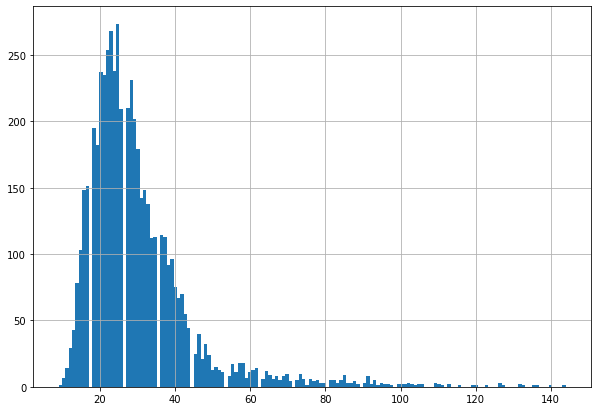

In [ ]:
stat_1 = pd.DataFrame(train_dataset['AllColumns'])[0].apply(lambda x: x.split(" ")).apply(len) # count the number of words for Conclusion + Premise + Stance
stat_1.hist(grid=True, bins=150, figsize=(10,7))
print('98 Percentile of story length is: ', int(stat_1.quantile(0.98)))
stat_1.describe()

From the training set, the maximum number of words for the concatenation of Conclusion, Stance and Premise is 144, below the input of most transformer models. For this reason, we took the maximum as input length for the model, to avoid truncation. Besides, the 90 percentile of the samples has less than 58 words. 

In [ ]:
input_length = int(stat_1.max())

Let's see the distribution of the Human Values on the training and validation set:

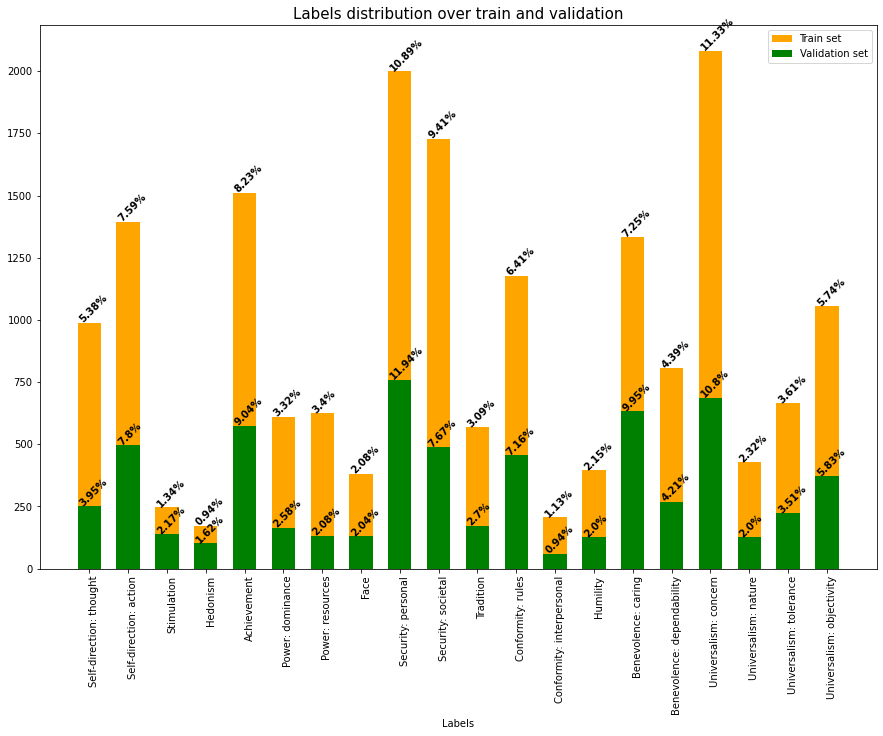

In [ ]:
values_train = dict(pd.DataFrame(train_dataset['labels']).iloc[:, :].sum())
values_val = dict(pd.DataFrame(val_dataset['labels']).iloc[:, :].sum())
plt.figure(figsize=(15,10))
plt.bar(target_names, values_train.values(), color='orange',width = 0.6)
total_train_labels = sum(list(values_train.values())) 
train_tot = sum(list(values_train.values()))
val_tot = sum(list(values_val.values())) 
for i, v in enumerate(list(values_train.values())):
    plt.text(i-0.3, v+1, str(round(v*100/train_tot,2))+'%', color='black', fontweight='bold', rotation = 45)
for i, v in enumerate(list(values_val.values())):
    plt.text(i-0.3, v+1, str(round(v*100/val_tot,2))+'%', color='black', fontweight='bold', rotation = 45)
plt.bar(target_names, values_val.values(), color='green',width = 0.6)
plt.legend(['Train set', 'Validation set'], fontsize=10)
plt.title('Labels distribution over train and validation', fontsize=15)
plt.xlabel('Labels', fontsize=10)
plt.xticks(rotation = 90, ha='right', rotation_mode='anchor')
plt.show()

Regarding the distribution of the 20 categories, we can see that the distribution of each class is almost the same between the training and validation set, with a difference that is at most by 2%. However, for each split the distribution of the categories is not homogeneous: there are 6 classes above the 7% of the total labels (which are the ones considered in the 6-labels task), 3 classes between the 5% and the 7% and all the others above the 5%.

## 3. 20-labels task
For this part, we simply take all the labels in the dataset (i.e. 20 labels).

### 3.1 SVM
SVMs are a type of supervised learning algorithm that can be used for classification tasks. In multilabel classification, each sample can have more than one label, meaning that the classification problem is not binary but multiclass. One way to approach multilabel classification with SVMs is to use the one-vs-rest (OvR) method.<br>
We have considered as input for the SVM only the premise, since the conclusion simply repeats the same words of the premise without adding any information to the context.<br>
For this model, we use a different preprocessing method in the ***build_dataset*** function, which includes lowercasing the text, tokenization, removing stopwords, and lemmatization. The ***svm_train*** dataframe below shows the difference before and after preprocessing on the premise column.

In [ ]:
svm_train = pd.DataFrame(build_dataset(train, target_names=target_names, clean='Premise'))[['Premise', 'PremiseCleaned', 'labels']]
svm_val = pd.DataFrame(build_dataset(val, target_names=target_names, clean='Premise'))[['Premise', 'PremiseCleaned', 'labels']]

In [ ]:
svm_train

,Premise,PremiseCleaned,labels
0,the security of child and teachers is esential...,security child teacher esential,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ..."
1,multi-party systems provide many new sources o...,multi party system provide many new source vie...,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,zoos often exhibit poor standards of animal we...,zoo often exhibit poor standard animal welfare...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,for multiple reasons the right of intellectual...,multiple reason right intellectual property ab...,"[0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, ..."
4,student loans should not be subsidized just be...,student loan subsidized people chose go colleg...,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...
5388,missionary work preaches false information to ...,missionary work preaches false information unf...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
5389,halt all immigration from non-european or non-...,halt immigration non european non first world ...,"[0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ..."
5390,the eu leadership fails to carry out its funda...,eu leadership fails carry fundamental duty gua...,"[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ..."
5391,these products come mainly from large enterpri...,product come mainly large enterprise necessari...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


Then, we apply encoding of the inputs using the TF-IDF Vectorizer, considering unigrams and bigrams and taking only the most frequent 5,000 words. The n-gram and max_features values are treated as hyperparameters.

In [ ]:
def TF_IDF(train, val, x_column, y_column, ngram=(1,2), max_featuers = 5000):
  cv = TfidfVectorizer(ngram_range=ngram, max_features = max_featuers)
  X_train = list(train[x_column])
  y_train = list(train[y_column])
  X_val = list(val[x_column])
  y_val = list(val[y_column])
  cv.fit(X_train)
  X_train = cv.transform(X_train).toarray()
  X_val = cv.transform(X_val).toarray()
  return X_train, y_train, X_val, y_val, cv

X_train, y_train, X_val, y_val, cv = TF_IDF(svm_train, svm_val, 'PremiseCleaned', 'labels')

Here, we apply Principal Component Analysis (PCA) to reduce the dimension from 5,000 to 2,250, due to computational time constraints. We iterate over the number of components.

In [ ]:
pca = PCA(n_components=2250)
X_train = pca.fit_transform(X_train)
X_val = pca.transform(X_val)

For SVM, we find that the best configuration is the one with a rbf kernel, gamma=0.09 and C=10. however, we set the max_iter to only 500, due to computational problems.

In [ ]:
svc = svm.SVC(C=10, gamma=0.09, kernel='rbf', max_iter=500, class_weight='balanced')
multi_class_svc = OneVsRestClassifier(svc)
multi_class_svc.fit(X_train, y_train)
results = multi_class_svc.predict(X_val) # test on val
results_x = multi_class_svc.predict(X_train) # test on train (for seeing overfit)

Now, let's see the results for the train and validation:

In [ ]:
print('Macro F1 score for train split:\t', round(f1_score(y_train, results_x.tolist(), average='macro'), 2))
print('Macro F1 score for val split:\t', round(f1_score(y_val, results.tolist(), average='macro'), 2))

Macro F1 score for train split:	 0.37
Macro F1 score for val split:	 0.3


As we can see from the above results, the performance of the model is slightly higher (by 0.07) on the training set compared to the validation set. This behaviour also happens with the other two seeds: we found that this was the best result within our computational limits; however, we are aware that this difference indicates overfitting. Unfortunately, we were unable to perform a complete hyperparameter tuning due to resource constraints, as our resources were exhausted above 500 iterations with the ***rbf*** kernel.<br>
The results with different seeds can be found at the end of the ***20-labels Task*** section, in the ***Results*** paragraph.

In [ ]:
# here, we save the SVM and PCA models in our directory with different seeds (42, 2022, 1337), using the pickle library

# save the SVM model 
# filename = 'SVM_20_42.sav'
# pickle.dump(multi_target_svc, open(filename, 'wb'))
#loaded_model = pickle.load(open(filename, 'rb'))

# save the PCA model
# filename = 'PCA_20_42.sav'
# pickle.dump(pca, open(filename, 'wb'))
#loaded_model = pickle.load(open(filename, 'rb'))

### 3.2 XLNet Large
The first step in using XLNet Large is to load the model from Hugging Face using ***XLNetForSequenceClassification***. We use this type of model because it has the best performances on this task compared to other architectures (like BERT). We choose to use the large version of XLNet because the computational cost is low due to the small size of the dataset.

In [ ]:
model_name = 'xlnet-large-cased'
model = XLNetForSequenceClassification.from_pretrained(model_name, num_labels=len(target_names), 
                                                       problem_type="multi_label_classification", output_hidden_states = False)
print('The number of parameters for {0} is: {1}'.format(model_name, sum(p.numel() for p in model.parameters() if p.requires_grad)))

Downloading:   0%|          | 0.00/761 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.44G [00:00<?, ?B/s]

The number of parameters for xlnet-large-cased is: 361338900


Then, we modify the classification head for our dataset to prevent overfitting by using Dropout. In the 20-label task, we increase the Dropout probability from 0.1 to 0.3. We treat the Dropout probability and the number of hidden layers as hyperparameters, and the best configuration is the one with Dropout and Linear. In our case, the Classifier Head is called ***logits_proj***.

In [ ]:
model.logits_proj = nn.Sequential(nn.Dropout(0.3), nn.Linear(1024,len(target_names)))

In [ ]:
# Here, you can see the model in details:
model

XLNetForSequenceClassification(
  (transformer): XLNetModel(
    (word_embedding): Embedding(32000, 1024)
    (layer): ModuleList(
      (0): XLNetLayer(
        (rel_attn): XLNetRelativeAttention(
          (layer_norm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (ff): XLNetFeedForward(
          (layer_norm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
          (layer_1): Linear(in_features=1024, out_features=4096, bias=True)
          (layer_2): Linear(in_features=4096, out_features=1024, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (activation_function): GELUActivation()
        )
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (1): XLNetLayer(
        (rel_attn): XLNetRelativeAttention(
          (layer_norm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (ff): XLNetFeedF

In the end, we decided to reset the weights of the last 3 layers, which we treated as hyperparameters. In general, the first layers allow the model to identify general features, while the last layers identify complex features specific to the task and dataset.<br>
Code from: [On Stability of Few-Sample Transformer Fine-Tuning, CommonLit Readability Prize](https://www.kaggle.com/code/rhtsingh/on-stability-of-few-sample-transformer-fine-tuning)

In [ ]:
reinit_layers = 3 # hyperparameters
if reinit_layers > 0:
    print(f'Reinitializing Last {reinit_layers} Layers ...')
    encoder_temp = getattr(model, 'transformer') # access to the model via 'transformer' attribute
    for layer in encoder_temp.layer[-reinit_layers:]: # access to the layers and reset the weights for the last 3 layers
        for module in layer.modules():
            if isinstance(module, nn.Linear):
                module.weight.data.normal_(mean=0.0, std=model.config.initializer_range)
                if module.bias is not None:
                    module.bias.data.zero_()
            elif isinstance(module, nn.Embedding):
                module.weight.data.normal_(mean=0.0, std=model.config.initializer_range)
                if module.padding_idx is not None:
                    module.weight.data[module.padding_idx].zero_()
            elif isinstance(module, nn.LayerNorm):
                module.bias.data.zero_()
                module.weight.data.fill_(1.0)
    print('Done.!')

Reinitializing Last 3 Layers ...
Done.!


Another import step is to define the tokenizer which we used as embedding for out XLNet model.

In [ ]:
def load_tokenizer(name):
  tokenizer = AutoTokenizer.from_pretrained(name)
  
  # we use CLS also for BOS, and SEP for EOS
  tokenizer.bos_token = tokenizer.cls_token
  tokenizer.eos_token = tokenizer.sep_token
  print('Tokenizer: {0}, Special Token used: {1}, {2}'.format(name, tokenizer.bos_token, tokenizer.eos_token))
  return tokenizer

In [ ]:
tokenizer_xlnet = load_tokenizer(model_name)

Downloading:   0%|          | 0.00/798k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.38M [00:00<?, ?B/s]

Tokenizer: xlnet-large-cased, Special Token used: <cls>, <sep>


Let's see some info about the tokenizer:

In [ ]:
cls_token = tokenizer_xlnet.cls_token
sep_token = tokenizer_xlnet.sep_token
pad_token = tokenizer_xlnet.pad_token
print('Tokenizer Special Words:', cls_token, sep_token, pad_token)
cls_token_idx = tokenizer_xlnet.cls_token_id
sep_token_idx = tokenizer_xlnet.sep_token_id
pad_token_idx = tokenizer_xlnet.pad_token_id
print('Embedding of the previous words:', cls_token_idx, sep_token_idx, pad_token_idx)

Tokenizer Special Words: <cls> <sep> <pad>
Embedding of the previous words: 3 4 5


Then, we encode the input with the tokenizer: we pass the Conclusion as the first sentence, while Stance + Premise as second sentence. This was chosen because the conclusion is typically either in favor of or against the premise. The max length defined previously is 144, i.e. the maximum number of words in a sample, so we also use padding and truncation (the validation set may overtake the training maximum length).

In [ ]:
# tokenizer --> the tokenizer used for the encoding;
# sx --> the name(s) of the column(s) for the first sentence of the tokenizer;
# dx --> the name(s) of the column(s) for the second sentence of the tokenizer;
# max_length --> the maximum length for the tokenizer
def process_data_to_model_inputs(batch, tokenizer, sx, dx, max_length):
  inputs = tokenizer(batch[sx], batch[dx], padding = 'max_length', max_length = max_length, truncation = True)
  batch['input_ids'] = inputs.input_ids.copy()
  batch['attention_mask'] = inputs.attention_mask.copy()
  batch['token_type_ids'] = inputs.token_type_ids.copy()
  return batch

In [ ]:
# map the train dataset for building the inputs for the models
train_mapped = train_dataset.map(lambda x: process_data_to_model_inputs(x, tokenizer_xlnet, 'Conclusion', 'Stance+Premise', input_length), batched = True, batch_size = 32)

# we convert the results into torch 
train_mapped.set_format(type="torch")

  0%|          | 0/169 [00:00<?, ?ba/s]

The final dataset also contains useless columns for the model (e.g. Conclusion, Premise, etc), but the model simply will ignore them.<br>
Then, we do the same for the validation split.

In [ ]:
val_mapped = val_dataset.map(lambda x: process_data_to_model_inputs(x, tokenizer_xlnet, 'Conclusion', 'Stance+Premise', input_length), batched=True, batch_size=32)
val_mapped.set_format(type="torch")

  0%|          | 0/60 [00:00<?, ?ba/s]

In [ ]:
# let's see if the tokenizer is working:
tokenizer_xlnet.decode(train_mapped['input_ids'][0])

'<pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad> we should adopt a zero-tolerance policy in schools.<sep> in favor of the security of child and teachers is esential for all.<sep><cls>'

Before starting the model, we define the metrics used for the validation split. Since we have multi-labels task, we use the sigmoid function of PyTorch with a default Threshold fixed to 0.5 (i.e. all the values over the threshold, are set to 1). After the training, we iterate the threshold for finding the best F1 according to the threshold.<br>
Code of compute_metrics from: [Longformer Multilabel Text Classification, Jesus Leal ML](https://jesusleal.io/2021/04/21/Longformer-multilabel-classification/)

In [ ]:
# source: https://jesusleal.io/2021/04/21/Longformer-multilabel-classification/ 
def multi_label_metrics(predictions, labels, threshold=0.5): 
  
  # first, apply sigmoid on predictions which are of shape (batch_size, num_labels) 
  sigmoid = torch.nn.Sigmoid() 
  probs = sigmoid(torch.Tensor(predictions)) 
  
  # next, use threshold to turn them into integer predictions 
  y_pred = np.zeros(probs.shape) 
  y_pred[np.where(probs >= threshold)] = 1 
  
  # finally, compute metrics 
  y_true = labels 
  f1_micro_average = f1_score(y_true=y_true, y_pred=y_pred, average='macro') 
  roc_auc = roc_auc_score(y_true, y_pred, average = 'macro') 
  accuracy = accuracy_score(y_true, y_pred) 
  
  # return as dictionary 
  metrics = {'f1': f1_micro_average, 'roc_auc': roc_auc, 'accuracy': accuracy} 
  return metrics 
  
def compute_metrics(p: EvalPrediction): 
  preds = p.predictions[0] if isinstance(p.predictions, tuple) else p.predictions
  result = multi_label_metrics(predictions=preds, labels=p.label_ids) 
  return result

For the fine-tuning, we use the steps proposed by [BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding, Devlin et all](https://arxiv.org/pdf/1810.04805.pdf):<br>
- lr = 2e-5;
- batch_size = 16;
- warmup;
- num_training_steps = length of the dataset * epochs.<br>

Besides, we stop the epochs when the validation loss exceed the previous validation loss.

In [ ]:
# since a for loop isn't computationally sustainable for these models, 
# we ran this notebook multiple time with different seeds.

model.to("cuda")
epochs = 4 
batch_size = 16
os.environ["WANDB_DISABLED"] = "true"

# define the training arguments (eval_step, epochs, output for checkpoint, etc)
training_args = TrainingArguments(
    output_dir='./drive2/MyDrive2/checkpoint',
    evaluation_strategy="epoch",
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    overwrite_output_dir=True,
    save_total_limit=3,
    fp16=True, 
    num_train_epochs = epochs,
    weight_decay=0.01,
    resume_from_checkpoint = True
)

# Adam and scheduler
optimizer=AdamW(model.parameters(),lr= 2e-5)
scheduler=get_cosine_schedule_with_warmup(optimizer=optimizer,num_warmup_steps=500,num_training_steps=train_mapped.shape[0]*epochs)
optimizers=optimizer, scheduler

# initialize trainer
trainer = Trainer(
    model=model,
    tokenizer=tokenizer_xlnet,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=train_mapped,
    eval_dataset=val_mapped,
    optimizers=optimizers
)

trainer.train()

# at the end, we save the model in our directory:
# torch.save(model, "/content/drive/MyDrive/NLP/TORCH-20-42")

In [ ]:
image_url = "https://raw.githubusercontent.com/DitucSpa/Human-Values-Detection/main/img/XLNetLarge_Epoch_20.png"
Image(url=image_url, width=500, height=140)

As we can see, the model doesn't overfit and we stop the training at the 4th epoch, when the validation loss started to get worse.

### 3.3 Useful functions for Results

In [ ]:
from statistics import mean

# this is a function used for testing the model, passing the tokenizer as parameter 
def generate_summary(batch, tokenizer):
    inputs = tokenizer(batch['Conclusion'], batch['Stance+Premise'], padding="max_length", truncation=True, max_length=input_length, return_attention_mask=True, return_tensors='pt')
    #inputs['labels']=torch.FloatTensor(batch['labels'])
    input_ids = inputs['input_ids'].to("cuda")
    attention_mask = inputs['attention_mask'].to("cuda")
    labels = torch.FloatTensor(batch['labels']).to('cuda')
    token_type_ids = inputs['token_type_ids'].to("cuda")
    outputs = model(input_ids=input_ids,attention_mask=attention_mask, token_type_ids=token_type_ids,labels=labels)
    batch['outputs']=outputs[1]
    return batch

# iterate over the threshold for finding the best macro F1
def FindBestThreshold(min_value, max_value, step, true, predicted, target_names):
  max = []
  for thresh in np.arange(min_value,max_value,step):
    sigmoid = torch.nn.Sigmoid() 
    probs = sigmoid(torch.Tensor(predicted))
    y_pred = np.zeros(probs.shape)
    y_pred[np.where(probs >= thresh)] = 1 
    f1 = f1_score(true, y_pred, average='macro',zero_division=0)
    max.append({'threshold':thresh, 'f1':f1, 'classification_report':classification_report(true, y_pred, zero_division=0, target_names=target_names, output_dict=True)})
  return pd.DataFrame(max)

# it creates a dict with F1 and support for each classes.
def CreateDict(reports, remove_columns=['micro avg', 'macro avg', 'weighted avg', 'samples avg']):
  f1_results = {}
  for i in range(len(reports)):
    keys = list(reports[i].keys())
    for k in remove_columns:
      keys.remove(k)
    for k in keys:
      if f1_results.get(k, False): 
        f1_results[k]['f1-score']+=reports[i][k]['f1-score']
      else: 
        f1_results[k] = {'f1-score':0, 'support':0}
        f1_results[k]['f1-score']=reports[i][k]['f1-score']
        f1_results[k]['support']=reports[i][k]['support']
  for k in keys:
    f1_results[k]['f1-score']=round(f1_results[k]['f1-score']/len(reports),2)
  return f1_results

# print the report
def PrintReport(report):
  print("Classification Report:")
  for k in list(report.keys()):
    tab = '\t\t'
    if len(k)>24: tab = '\t'
    elif len(k)<15 and len(k)>=7: tab='\t\t\t'
    elif len(k)<7: tab='\t\t\t\t'
    print('Label: {0},{1}F1: {2},\tSupport: {3} '.format(k, tab, report[k]['f1-score'], report[k]['support']))

# plot the F1 for each classes for each model passed.
# model is defined as a dictionary, such as {'model_name':classification_report_dict} where classification_report_dict is the output (in dict)
# of the classification report function of sklearn.
# position_mean --> the position of the F1 mean text on the image
def PlotModelsF1(models, target_names, position_mean=-0.3):
  colors = ['#1f77b4', '#ffa500', 'g', 'r', 'k', 'y', 'c']
  if len(models) > len(colors):
    print("ERROR: you can use at most 7 different models.")
    return
  x_plt = np.arange(0,len(target_names))
  plt.figure(figsize=(15, 5))
  count = 0
  for k in list(models.keys()):
    model_name = k
    model_val = []
    distribution = []
    for i in target_names:
      model_val.append(models[k][i]['f1-score'])
      distribution.append(models[k][i]['support'])
    # add the F1 results for the current model
    plt.plot(model_val[0:len(target_names)], '--o', color=colors[count], label=model_name)
    plt.plot([mean(model_val)]*len(target_names), color=colors[count], linestyle='-')
    value = str(round(mean(model_val), 2))
    if len(value)<4: value += '0'
    plt.text(x=position_mean, y=mean(model_val), s=value, color=colors[count], fontsize=12, fontweight='bold')
    count += 1
  plt.bar(x_plt,[x / sum(distribution) for x in distribution], label="Support")
  plt.xlabel('Labels')
  plt.ylabel('F1-score')
  plt.xticks(x_plt, target_names, rotation=45, ha='right', rotation_mode='anchor')
  plt.tick_params(labelleft=True)
  plt.yticks(np.linspace(0,1, num=11))
  plt.legend()
  plt.show()

import math
# it computes the DF
def Compute_df(dataframe, list_of_words, target_names):
  df = {}
  for word in list_of_words:
    df[word] = 0
    for m in target_names:
      temporany = dataframe.copy()
      temporany['concat'] = temporany['Conclusion'] + ' ' + temporany['Premise'] # concatenate conclusion and premise
      temporany = list(temporany[temporany[m]==1]['concat'])
      temporany = list(set([english_lemmatizer.lemmatize(k) for k in re.sub('[\W]', ' ', ' '.join(temporany).lower()).split(' ') if k not in stopwords_list]))
      if word in temporany:
        df[word] += 1
        continue
  return df


# it computes the TF-IDF
def PlotWordsDistribution(dataset, attribute, frequency=15):

  # first step: get the vocabulary for the attribute passed (e.g. for "Face" we build the vocabulary with all the words that appear in the "Face" label)
  tmp = dataset.copy()
  tmp['concat'] = tmp['Conclusion'] + ' ' + tmp['Premise'] # concatenate conclusion and premise
  tmp = list(tmp[tmp[attribute]==1]['concat'])
  counts = Counter([english_lemmatizer.lemmatize(k) for k in re.sub('[\W]', ' ', ' '.join(tmp).lower()).split(' ') if k not in stopwords_list]) # preprocessing of the words
  words_frequency_actual = {}
  for element, count in counts.items():
    words_frequency_actual[element]=count
  del words_frequency_actual[''] # remove the empty char
  
  # second step: order the vocabulary by the frequency and taking only the most X words (attribute frequency)
  sorted_dict = sorted(words_frequency_actual.items(), key=lambda x: x[1], reverse=True)[:frequency]
  most_frequency_words = [w for w, v in sorted_dict] # stored the most X words for the actual attribute
  df = Compute_df(dataset, most_frequency_words, target_names)
  
  # third step: create a pandas dataframe where:
  # - the rows correspond to the all attributes of the dataset (in our case the 20 labels);
  # - each column corresponds to the most X words;
  # - the value in each cell is the TF-IDF
  # for example the most frequent word in "Face" is "energy", so we compute the number of times that "energy" appears in "Humility" wrt the number of words in "Humility" (e.g. TF) moltiply by
  # the logarithm inverse number of times that "energy" appears in the 20 labels, that is 12 of 20 (e.g. IDF).
  

  # Example of the table:
  # ColumnName  |   energy    |     loan    |    ....
  # --------------------------------------------------
  #    Face     |    0.56     |     0.23    |    ....
  #  Humility   |    0.01     |     0.12    |    ....
  #    ....     |    ....     |     ....    |    ....
  
  
  empty_list = []
  for target in target_names:
    dict_tmp = {}
    if target == attribute:    
      dict_tmp['ColumnName'] = attribute
      for word, frequency in sorted_dict:
        try:
          dict_tmp[word] = abs(words_frequency_actual[word]/sum(list(words_frequency_actual.values())) * math.log(len(target_names)/df[word],10))
        except: 
          dict_tmp[word] = 0
      empty_list.append(dict_tmp)
      continue
    tmp = val.copy()
    tmp['concat'] = val['Conclusion'] + ' ' + val['Premise']
    tmp = list(tmp[(tmp[attribute]==0) & (tmp[target]==1)]['concat'])
    counts = Counter([english_lemmatizer.lemmatize(k) for k in re.sub('[\W]', ' ', ' '.join(tmp).lower()).split(' ') if k not in stopwords_list])
    words_frequency = {}
    for element, count in counts.items():
      words_frequency[element]=count
    del words_frequency['']
    dict_tmp['ColumnName'] = target
    for word, frequency in sorted_dict:
      try:
        dict_tmp[word] = abs(words_frequency[word]/sum(list(words_frequency.values())) * math.log(len(target_names)/df[word],10))
      except Exception as ex:
        dict_tmp[word] = 0
    empty_list.append(dict_tmp)
  return pd.DataFrame(empty_list)

### 3.4 Results
Here, we define some useful functions for plotting and printing the results (you can skip this cell).

Load the SVM and PCA model with different seeds:

In [ ]:
path = '/content/drive/MyDrive/NLP' # load the folder with the weights from the drive
reports = []
try:
  for filename in os.listdir(path):
    pca = None
    svm = None
    if "PCA_SVM_20" in filename:
      for f in os.listdir(path+'/'+filename):
        if 'PCA' in f: 
          pca = pickle.load(open(path+'/'+filename+'/'+f, 'rb'))
        else: svm = pickle.load(open(path+'/'+filename+'/'+f, 'rb'))
      if not(pca and svm): raise Exception("Some files are missing!")
      X_train, y_train, X_val, y_val, cv = TF_IDF(svm_train, svm_val, 'PremiseCleaned', 'labels')
      results = svm.predict(pca.transform(X_val))
      reports.append(classification_report(y_val, results.tolist(), target_names=target_names, output_dict=True))
except Exception as ex: print(ex)

In [ ]:
f1_results_svm = CreateDict(reports)
print("Macro F1 score:", round(mean([f1_results_svm[k]['f1-score'] for k in list(f1_results_svm.keys())]),2))
print()
PrintReport(f1_results_svm)
svm_results = results

Macro F1 score: 0.3

Classification Report:
Label: Self-direction: thought,		F1: 0.24,	Support: 251 
Label: Self-direction: action,		F1: 0.41,	Support: 496 
Label: Stimulation,			F1: 0.14,	Support: 138 
Label: Hedonism,			F1: 0.28,	Support: 103 
Label: Achievement,			F1: 0.47,	Support: 575 
Label: Power: dominance,		F1: 0.16,	Support: 164 
Label: Power: resources,		F1: 0.14,	Support: 132 
Label: Face,				F1: 0.13,	Support: 130 
Label: Security: personal,		F1: 0.57,	Support: 759 
Label: Security: societal,		F1: 0.41,	Support: 488 
Label: Tradition,			F1: 0.17,	Support: 172 
Label: Conformity: rules,		F1: 0.39,	Support: 455 
Label: Conformity: interpersonal,	F1: 0.14,	Support: 60 
Label: Humility,			F1: 0.13,	Support: 127 
Label: Benevolence: caring,		F1: 0.5,	Support: 633 
Label: Benevolence: dependability,	F1: 0.25,	Support: 268 
Label: Universalism: concern,		F1: 0.53,	Support: 687 
Label: Universalism: nature,		F1: 0.36,	Support: 127 
Label: Universalism: tolerance,		F1: 0.21,	Suppor

Load the XLNet Large models with different seeds:

In [ ]:
path = '/content/drive/MyDrive/NLP' # load the folder with the weights from the drive
thresholds = []
for filename in os.listdir(path):
  if 'TORCH-20' in filename:
    print(filename)
    model = torch.load("/content/drive/MyDrive/NLP/"+filename)
    model.to("cuda")
    model.eval()
    results = val_dataset.map(lambda x: generate_summary(x, tokenizer_xlnet), batched=True, batch_size=16)
    params = FindBestThreshold(0.0, 0.7, 0.01, results['labels'], results['outputs'], target_names)
    thresholds.append(params)

TORCH-20-1337


  0%|          | 0/119 [00:00<?, ?ba/s]

TORCH-20-2022


  0%|          | 0/119 [00:00<?, ?ba/s]

TORCH-20-42


  0%|          | 0/119 [00:00<?, ?ba/s]

For the XLNet Large parte, we need to find the best threshold, computed as mean of the thresholds between the seeds. After that, we computed the classification report for each seeds using the previous mean threshold; at the end, we report the mean F1s for each class.

In [ ]:
# find the mean threshold
mean_threshold = []
for i in range(len(thresholds)):
  mean_threshold.append(thresholds[i].iloc[thresholds[i]['f1'].idxmax()]['threshold'])
mean_threshold = round(mean(mean_threshold),2)
print('The mean threshold is:', mean_threshold)

# compute the classification report using the previous threshold
reports = []
for i in range(len(thresholds)):
  reports.append(thresholds[i][thresholds[i]['threshold']==mean_threshold]['classification_report'].item())

# compute the mean of all the F1s
f1_results_xln = CreateDict(reports)
print("Macro F1 score:", round(mean([f1_results_xln[k]['f1-score'] for k in list(f1_results_xln.keys())]), 2))
print()
PrintReport(f1_results_xln)
xlnet_results = results

The mean threshold is: 0.25
Macro F1 score: 0.49

Classification Report:
Label: Self-direction: thought,		F1: 0.52,	Support: 251 
Label: Self-direction: action,		F1: 0.58,	Support: 496 
Label: Stimulation,			F1: 0.33,	Support: 138 
Label: Hedonism,			F1: 0.48,	Support: 103 
Label: Achievement,			F1: 0.64,	Support: 575 
Label: Power: dominance,		F1: 0.33,	Support: 164 
Label: Power: resources,		F1: 0.49,	Support: 132 
Label: Face,				F1: 0.3,	Support: 130 
Label: Security: personal,		F1: 0.74,	Support: 759 
Label: Security: societal,		F1: 0.63,	Support: 488 
Label: Tradition,			F1: 0.49,	Support: 172 
Label: Conformity: rules,		F1: 0.61,	Support: 455 
Label: Conformity: interpersonal,	F1: 0.32,	Support: 60 
Label: Humility,			F1: 0.17,	Support: 127 
Label: Benevolence: caring,		F1: 0.61,	Support: 633 
Label: Benevolence: dependability,	F1: 0.38,	Support: 268 
Label: Universalism: concern,		F1: 0.68,	Support: 687 
Label: Universalism: nature,		F1: 0.71,	Support: 127 
Label: Universalism:

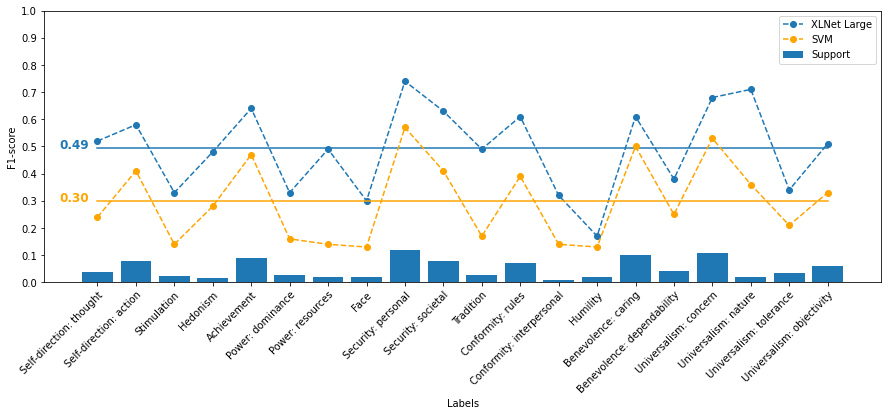

In [ ]:
PlotModelsF1({'XLNet Large':f1_results_xln, 'SVM':f1_results_svm}, target_names, position_mean=-1)

The image shows the F1-score across the 20 categories for both SVM and XLNet-large. It can be seen that XLNet-large consistently performs better than SVM for each class, as expected since SVM models do not consider word semantics, unlike Transformer models. Besides, it can also be observed that the F1-score trends for both approaches are similar across all categories, indicating that both models find each class equally challenging to predict, with the exceptions of the ***Universalism: nature*** and ***Power: resources*** categories, which appear to be easier for XLNet-large compared to the other categories than the SVM. Instead, ***Humility*** has poor performance for both models, even though the support is not minimal.

In [ ]:
tmp = val.copy()
attribute = "Power: resources"
tmp['concat'] = val['Conclusion'] + ' ' + val['Premise']
tmp = list(tmp[tmp[attribute]==1]['concat'])
tmp[:4]

['We should subsidize vocational education We should subsidize vocational education to encourage more trade schools to open.',
 'Payday loans should be banned a payday loan company serves the public.  they allow people that need their money now without waiting for the paycheck.  if people want to use these companies why should we stop them..',
 'Payday loans should be banned sometimes people need these emergency funds when they have no other available options.',
 'We should subsidize vocational education vocational education is extremely important to this country.   kids learning a trade  will later be able to get a job using what they learned.   government should help schools financially cover these costs.']

All of the previous results of the models have been stored in a CSV file called 'HMV_results_20-labels.csv', as shown below:

In [ ]:
model_results = pd.read_csv('HMV_results_20-labels.csv')
model_results.head()

,Conclusion,Stance,Premise,labels,XLNetLargePredictions,SVMPredictions
0,Entrapment should be legalized,in favor of,if entrapment can serve to more easily capture...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...","[1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, ..."
1,The use of public defenders should be mandatory,in favor of,the use of public defenders should be mandator...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, ...","[1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, ..."
2,Payday loans should be banned,in favor of,payday loans create a more impoverished societ...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, ...","[1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, ..."
3,Surrogacy should be banned,against,Surrogacy should not be banned as it is the wo...,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, ..."
4,Entrapment should be legalized,against,entrapment is gravely immoral and against huma...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, ..."


All the following results are reported also in the report.<br>
Below, you can find the TF-IDF between the 15 most common words in the considered labels wrt the labels.

A class with high F1 scores for both the models is Achievement. Let's see its tf-idf results:

In [ ]:
attribute = 'Achievement'
pandas_results_most_frequency = PlotWordsDistribution(val, attribute, 15)
pandas_results_most_frequency.style.background_gradient(cmap='Greens', subset=pandas_results_most_frequency.columns[1:])

,ColumnName,good,test,education,harm,intelligence,vocational,people,homeschooling,banned,subsidize,bring,child,public,brings,television
0,Self-direction: thought,0.000000,0.000022,0.000011,0.000000,0.000011,0.000000,0.000000,0.000243,0.000000,0.000000,0.000043,0.000000,0.000265,0.000000,0.000484
1,Self-direction: action,0.000000,0.000021,0.000054,0.000000,0.000017,0.000159,0.000000,0.000189,0.000000,0.000106,0.000029,0.000000,0.000327,0.000000,0.000075
2,Stimulation,0.000000,0.000078,0.000039,0.000000,0.000078,0.000124,0.000000,0.000321,0.000000,0.000062,0.000098,0.000000,0.000080,0.000000,0.000741
3,Hedonism,0.000000,0.000044,0.000000,0.000000,0.000044,0.000000,0.000000,0.000269,0.000000,0.000000,0.000044,0.000000,0.000000,0.000000,0.001114
4,Achievement,0.000000,0.000450,0.000429,0.000000,0.000392,0.001056,0.000000,0.000602,0.000000,0.000736,0.000230,0.000000,0.000376,0.000000,0.000174
5,Power: dominance,0.000000,0.000014,0.000014,0.000000,0.000000,0.000000,0.000000,0.000142,0.000000,0.000000,0.000014,0.000000,0.000170,0.000000,0.000083
6,Power: resources,0.000000,0.000035,0.000211,0.000000,0.000035,0.000613,0.000000,0.000000,0.000000,0.000502,0.000018,0.000000,0.000361,0.000000,0.000000
7,Face,0.000000,0.000106,0.000030,0.000000,0.000090,0.000000,0.000000,0.000526,0.000000,0.000000,0.000090,0.000000,0.000186,0.000000,0.000000
8,Security: personal,0.000000,0.000046,0.000074,0.000000,0.000038,0.000170,0.000000,0.000216,0.000000,0.000130,0.000056,0.000000,0.000116,0.000000,0.000131
9,Security: societal,0.000000,0.000016,0.000027,0.000000,0.000008,0.000074,0.000000,0.000032,0.000000,0.000037,0.000020,0.000000,0.000184,0.000000,0.000023


The Worst F1-score for both models corresponds to the class "Humility". Indeed, most of the most frequent words have TF-IDF equal to 0, and also the value of the word "test" is similar to the value of "Achievement".

In [ ]:
attribute = 'Humility'
pandas_results_most_frequency = PlotWordsDistribution(val, attribute, 15)
pandas_results_most_frequency.style.background_gradient(cmap='Greens', subset=pandas_results_most_frequency.columns[1:])

,ColumnName,people,good,test,harm,criminal,celibacy,suicide,vow,assisted,offence,abandoned,surrogacy,intelligence,banned,education
0,Self-direction: thought,0.000000,0.000000,0.000220,0.000000,0.000000,0.000240,0.000000,0.000233,0.000080,0.000446,0.000000,0.000033,0.000220,0.000000,0.000127
1,Self-direction: action,0.000000,0.000000,0.000057,0.000000,0.000000,0.000210,0.000000,0.000210,0.000165,0.000261,0.000000,0.000264,0.000048,0.000000,0.000223
2,Stimulation,0.000000,0.000000,0.000073,0.000000,0.000000,0.000182,0.000000,0.000194,0.000036,0.000061,0.000000,0.000231,0.000097,0.000000,0.000316
3,Hedonism,0.000000,0.000000,0.000036,0.000000,0.000000,0.000623,0.000000,0.000605,0.000018,0.000018,0.000000,0.000178,0.000036,0.000000,0.000053
4,Achievement,0.000000,0.000000,0.000407,0.000000,0.000000,0.000042,0.000000,0.000037,0.000017,0.000030,0.000000,0.000025,0.000363,0.000000,0.000414
5,Power: dominance,0.000000,0.000000,0.000016,0.000000,0.000000,0.000055,0.000000,0.000047,0.000039,0.000063,0.000000,0.000055,0.000016,0.000000,0.000039
6,Power: resources,0.000000,0.000000,0.000021,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000053,0.000021,0.000000,0.000553
7,Face,0.000000,0.000000,0.000285,0.000000,0.000000,0.000080,0.000000,0.000080,0.000011,0.000171,0.000000,0.000023,0.000239,0.000000,0.000091
8,Security: personal,0.000000,0.000000,0.000066,0.000000,0.000000,0.000029,0.000000,0.000027,0.000083,0.000079,0.000000,0.000124,0.000060,0.000000,0.000209
9,Security: societal,0.000000,0.000000,0.000021,0.000000,0.000000,0.000073,0.000000,0.000067,0.000106,0.000213,0.000000,0.000043,0.000018,0.000000,0.000125


The importance of the tf-idf values can be seen for the class "Universalism: nature". In this case the support is very low, but there are many words that identify the class.

In [ ]:
attribute = 'Universalism: nature'
pandas_results_most_frequency = PlotWordsDistribution(val, attribute, 15)
pandas_results_most_frequency.style.background_gradient(cmap='Greens', subset=pandas_results_most_frequency.columns[1:])

,ColumnName,energy,natural,nuclear,homeopathy,use,good,harm,people,promote,climate,farming,brings,plant,make,change
0,Self-direction: thought,0.000067,0.000000,0.000000,0.000081,0.000000,0.000000,0.000000,0.000000,0.000043,0.000000,0.000000,0.000000,0.000000,0.000000,0.000043
1,Self-direction: action,0.000095,0.000042,0.000000,0.000121,0.000000,0.000000,0.000000,0.000000,0.000040,0.000000,0.000000,0.000000,0.000037,0.000000,0.000071
2,Stimulation,0.000000,0.000051,0.000000,0.000047,0.000000,0.000000,0.000000,0.000000,0.000037,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,Hedonism,0.000000,0.000000,0.000000,0.000089,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,Achievement,0.000127,0.000011,0.000025,0.000120,0.000000,0.000000,0.000000,0.000000,0.000048,0.000018,0.000000,0.000000,0.000000,0.000000,0.000073
5,Power: dominance,0.000000,0.000000,0.000322,0.000105,0.000000,0.000000,0.000000,0.000000,0.000077,0.000000,0.000000,0.000000,0.000000,0.000000,0.000103
6,Power: resources,0.000532,0.000139,0.000532,0.000011,0.000000,0.000000,0.000000,0.000000,0.000237,0.000000,0.000577,0.000000,0.000000,0.000000,0.000068
7,Face,0.000000,0.000000,0.000000,0.000021,0.000000,0.000000,0.000000,0.000000,0.000034,0.000000,0.000000,0.000000,0.000000,0.000000,0.000034
8,Security: personal,0.000118,0.000051,0.000118,0.000215,0.000000,0.000000,0.000000,0.000000,0.000069,0.000000,0.000107,0.000000,0.000000,0.000000,0.000056
9,Security: societal,0.000091,0.000000,0.000272,0.000043,0.000000,0.000000,0.000000,0.000000,0.000039,0.000000,0.000000,0.000000,0.000000,0.000000,0.000029


Another particular case is "Power: resources". Here the support is very low, but there are many words that identify this label. Indeed, the F1 for XLNet Large is 0.49. However, the F1 of the SVM is very low, which can be explained by the fact that we did not implement fine-tuning well. Indeed, we plot all the vocabulary and we note the same behaviour.

In [ ]:
attribute = 'Power: resources'
pandas_results_most_frequency = PlotWordsDistribution(val, attribute, 80)
pandas_results_most_frequency.style.background_gradient(cmap='Greens', subset=pandas_results_most_frequency.columns[1:])

,ColumnName,loan,payday,education,vocational,banned,subsidize,people,public,defender,money,use,need,pay,job,gaza,mandatory,would,time,blockade,get,able,strip,cost,financial,ended,better,good,budget,country,government,help,year,interest,make,economy,school,college,harm,way,promote,trade,economic,debt,increase,afford,could,living,farming,high,even,expensive,person,many,brings,take,case,waste,due,zero,natural,health,encourage,want,stop,important,graduate,already,best,much,give,subsidized,area,bill,resource,right,useful,surrogacy,child,foster,care
0,Self-direction: thought,0.000000,0.000000,0.000109,0.000163,0.000000,0.000081,0.000000,0.000224,0.000335,0.000053,0.000000,0.000000,0.000000,0.000040,0.000081,0.000279,0.000000,0.000000,0.000102,0.000000,0.000000,0.000040,0.000000,0.000000,0.000081,0.000000,0.000000,0.000000,0.000066,0.000040,0.000000,0.000000,0.000041,0.000000,0.000000,0.000079,0.000000,0.000000,0.000000,0.000061,0.000089,0.000036,0.000000,0.000006,0.000036,0.000000,0.000000,0.000087,0.000056,0.000079,0.000000,0.000000,0.000000,0.000000,0.000000,0.000041,0.000036,0.000000,0.000000,0.000028,0.000013,0.000020,0.000109,0.000045,0.000000,0.000000,0.000006,0.000000,0.000039,0.000000,0.000000,0.000041,0.000000,0.000028,0.000000,0.000045,0.000032,0.000000,0.000000,0.000000
1,Self-direction: action,0.000499,0.000476,0.000186,0.000444,0.000000,0.000289,0.000000,0.000335,0.000639,0.000027,0.000000,0.000000,0.000159,0.000067,0.000279,0.000511,0.000000,0.000000,0.000269,0.000000,0.000000,0.000181,0.000041,0.000057,0.000186,0.000000,0.000000,0.000000,0.000154,0.000114,0.000000,0.000156,0.000031,0.000000,0.000114,0.000154,0.000027,0.000000,0.000000,0.000052,0.000091,0.000055,0.000038,0.000013,0.000073,0.000000,0.000016,0.000000,0.000114,0.000047,0.000038,0.000000,0.000000,0.000000,0.000000,0.000062,0.000037,0.000085,0.000000,0.000142,0.000029,0.000021,0.000095,0.000046,0.000000,0.000027,0.000010,0.000000,0.000033,0.000000,0.000097,0.000031,0.000058,0.000043,0.000000,0.000091,0.000261,0.000000,0.000000,0.000046
2,Stimulation,0.000000,0.000000,0.000247,0.000633,0.000000,0.000372,0.000000,0.000121,0.000153,0.000024,0.000000,0.000000,0.000163,0.000024,0.000000,0.000102,0.000000,0.000000,0.000000,0.000000,0.000000,0.000024,0.000112,0.000000,0.000000,0.000000,0.000000,0.000099,0.000072,0.000000,0.000000,0.000000,0.000112,0.000000,0.000000,0.000217,0.000099,0.000000,0.000000,0.000037,0.000082,0.000132,0.000000,0.000012,0.000000,0.000000,0.000035,0.000000,0.000153,0.000121,0.000000,0.000000,0.000000,0.000000,0.000000,0.000074,0.000132,0.000000,0.000000,0.000102,0.000024,0.000000,0.000059,0.000012,0.000000,0.000099,0.000035,0.000000,0.000071,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000223,0.000000,0.000000,0.000094
3,Hedonism,0.000000,0.000000,0.000048,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000066,0.000000,0.000000,0.000051,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000016,0.000000,0.000000,0.000032,0.000000,0.000070,0.000033,0.000000,0.000000,0.000000,0.000000,0.000000,0.000051,0.000000,0.000000,0.000000,0.000140,0.000048,0.000000,0.000000,0.000000,0.000000,0.000000,0.000016,0.000000,0.000048,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000161,0.000000,0.000000,0.000064
4,Achievement,0.000072,0.000072,0.000343,0.000765,0.000000,0.000543,0.000000,0.000320,0.000587,0.000048,0.000000,0.000000,0.000090,0.000123,0.000132,0.000429,0.000000,0.000000,0.000148,0.000000,0.000000,0.000075,0.000041,0.000102,0.000090,0.000000,0.000000,0.000044,0.000171,0.000064,0.000000,0.000169,0.000058,0.000000,0.000091,0.000187,0.000218,0.000000,0.000000,0.000082,0.000108,0.000073,0.000030,0.000026,0.000029,0.000000,0.000010,0.000105,0.000113,0.000064,0.000000,0.000000,0.000000,0.0

## 4. 6-labels task
Here, we can use SVM and XLNet (with a different fine-tuning and classification head) using only the most frequent labels (i.e. Self-direction: action, Achievement, Security: personal, Security: societal, Benevolence: caring, Universalism: concern, proposed by the Authors of the original paper).<br>
In this section, we report only the hyperparameters that change from the 20-labels task.

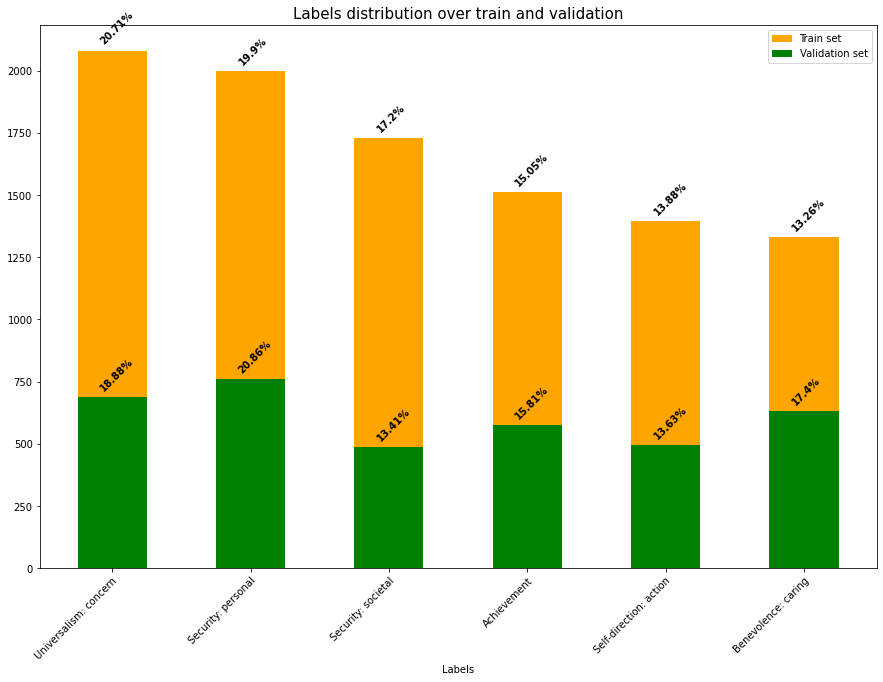

In [ ]:
target_names = get_target_names(train, 4, most_frequency=True)
train_dataset = build_dataset(train, target_names=target_names)
val_dataset = build_dataset(val, target_names=target_names)
values_train = dict(pd.DataFrame(train_dataset['labels']).iloc[:, :].sum())
values_val = dict(pd.DataFrame(val_dataset['labels']).iloc[:, :].sum())
plt.figure(figsize=(15,10))
plt.bar(target_names, values_train.values(), color='orange',width = 0.5)
total_train_labels = sum(list(values_train.values())) 
train_tot = sum(list(values_train.values()))
val_tot = sum(list(values_val.values())) 
for i, v in enumerate(list(values_train.values())):
    plt.text(i-0.1, v+25, str(round(v*100/train_tot,2))+'%', color='black', fontweight='bold', rotation = 45)
for i, v in enumerate(list(values_val.values())):
    plt.text(i-0.1, v+25, str(round(v*100/val_tot,2))+'%', color='black', fontweight='bold', rotation = 45)
plt.bar(target_names, values_val.values(), color='green',width = 0.5)
plt.legend(['Train set', 'Validation set'], fontsize=10)
plt.title('Labels distribution over train and validation', fontsize=15)
plt.xlabel('Labels', fontsize=10)
plt.xticks(rotation = 45, ha='right', rotation_mode='anchor')
plt.show()

### 4.1 SVM
For the 6-labels task, we saw that the best configuration is the one with the linear kernel, C=0.4 and max_iter=2250.

In [ ]:
svm_train = pd.DataFrame(build_dataset(train, target_names=target_names, clean='Premise'))[['Premise', 'PremiseCleaned', 'labels']]
svm_val = pd.DataFrame(build_dataset(val, target_names=target_names, clean='Premise'))[['Premise', 'PremiseCleaned', 'labels']]

In [ ]:
X_train, y_train, X_val, y_val, cv = TF_IDF(svm_train, svm_val, 'PremiseCleaned', 'labels')
pca = PCA(n_components=2250)
X_train = pca.fit_transform(X_train)
X_val = pca.transform(X_val)
svc = svm.SVC(C=0.4, kernel='linear', max_iter=2250, class_weight='balanced')
multi_class_svc = OneVsRestClassifier(svc)
multi_class_svc.fit(X_train, y_train)
results = multi_class_svc.predict(X_val) # test on val
results_x = multi_class_svc.predict(X_train) # test on train (for seeing overfit)
print('Macro F1 score for train split:\t', round(f1_score(y_train, results_x.tolist(), average='macro'), 2))
print('Macro F1 score for val split:\t', round(f1_score(y_val, results.tolist(), average='macro'), 2))

Macro F1 score for train split:	 0.6
Macro F1 score for val split:	 0.52


As we can see from the above results, the performance of the model is slightly higher (by 0.08) on the training set compared to the validation set. This behaviour also happens with the other two seeds: we found that this was the best result within our computational limits; however, we are aware that this difference indicates overfitting. Indeed, we were only able to test a small range of hyperparameters due to computational constraints.<br>
The results with different seeds can be found at the end of the ***6-labels Task*** section, in the ***Results*** paragraph.

### 4.2 XLNet Large

In [ ]:
model_name = 'xlnet-large-cased'
model = XLNetForSequenceClassification.from_pretrained(model_name, num_labels=len(target_names), 
                                                       problem_type="multi_label_classification", output_hidden_states = False)
print('The number of parameters for {0} is: {1}'.format(model_name, sum(p.numel() for p in model.parameters() if p.requires_grad)))

The number of parameters for xlnet-large-cased is: 361324550


We modify the classification head with:
- Dense from 1024 to 24;
- ReLU;
- Dropout with 0.5 probability;
- Dense from 24 to 6.

In [ ]:
model.logits_proj = nn.Sequential(nn.Linear(1024,len(target_names)*3), nn.ReLU(True), nn.Dropout(0.5), nn.Linear(len(target_names)*3,len(target_names)))

Then, we use the same tokenizer with the new labels. For the fine-tuning part, we use the same steps defined by Devlin et all, as we've seen in the previous chapter. Here, you can see the performance of the model with seed 42 using 5 epochs (fixed to maximum 5 due to computational and time issues).<br>
In particular, we pay attention to overfitting instead of performance. The results with all the same can be found in the ***Results*** section.

In [ ]:
image_url = "https://raw.githubusercontent.com/DitucSpa/Human-Values-Detection/main/img/XLNETLarge_Epoch_6.png"
Image(url=image_url, width=500, height=170)

### 4.3 Results

Now, let's upload the PCA and SVM model with different seeds.

In [ ]:
path = '/content/drive/MyDrive/NLP' # load the folder with the weights from the drive
reports = []
try:
  for filename in os.listdir(path):
    pca = None
    svm = None
    if "PCA_SVM_6" in filename:
      for f in os.listdir(path+'/'+filename):
        if 'PCA' in f: 
          pca = pickle.load(open(path+'/'+filename+'/'+f, 'rb'))
        else: svm = pickle.load(open(path+'/'+filename+'/'+f, 'rb'))
      if not(pca and svm): raise Exception("Some files are missing!")
      X_train, y_train, X_val, y_val, cv = TF_IDF(svm_train, svm_val, 'PremiseCleaned', 'labels')
      results = svm.predict(pca.transform(X_val))
      reports.append(classification_report(y_val, results.tolist(), target_names=target_names, output_dict=True))
except Exception as ex: print(ex)

[Errno 2] No such file or directory: '/content/drive/MyDrive/NLP'


In [ ]:
f1_results_svm = CreateDict(reports)
print("Macro F1 score:", round(mean([f1_results_svm[k]['f1-score'] for k in list(f1_results_svm.keys())]),2))
print()
PrintReport(f1_results_svm)
svm_results = results

Macro F1 score: 0.52

Classification Report:
Label: Universalism: concern,		F1: 0.55,	Support: 687 
Label: Security: personal,		F1: 0.64,	Support: 759 
Label: Security: societal,		F1: 0.45,	Support: 488 
Label: Achievement,			F1: 0.49,	Support: 575 
Label: Self-direction: action,		F1: 0.47,	Support: 496 
Label: Benevolence: caring,		F1: 0.5,	Support: 633 


Here, we upload the XLNet Large models:

In [ ]:
path = '/content/drive/MyDrive/NLP' # load the folder with the weights from the drive
thresholds = []
for filename in os.listdir(path):
  if 'TORCH-6' in filename:
    print(filename)
    model = torch.load("/content/drive/MyDrive/NLP/"+filename)
    model.to("cuda")
    model.eval()
    results = val_dataset.map(lambda x: generate_summary(x, tokenizer_xlnet), batched=True, batch_size=16)
    params = FindBestThreshold(0.0, 0.7, 0.01, results['labels'], results['outputs'], target_names)
    thresholds.append(params)

TORCH-6-2022


  0%|          | 0/119 [00:00<?, ?ba/s]

TORCH-6-42


  0%|          | 0/119 [00:00<?, ?ba/s]

TORCH-6-1337


  0%|          | 0/119 [00:00<?, ?ba/s]

In [ ]:
mean_threshold = []
for i in range(len(thresholds)):
  mean_threshold.append(thresholds[i].iloc[thresholds[i]['f1'].idxmax()]['threshold'])
mean_threshold = round(mean(mean_threshold),2)
print('The mean threshold is:', mean_threshold)

reports = []
for i in range(len(thresholds)):
  reports.append(thresholds[i][thresholds[i]['threshold']==mean_threshold]['classification_report'].item())

f1_results_xln = CreateDict(reports)
print("Macro F1 score:", round(mean([f1_results_xln[k]['f1-score'] for k in list(f1_results_xln.keys())]),2))
print()
PrintReport(f1_results_xln)
xlnet_results = results

The mean threshold is: 0.43
Macro F1 score: 0.62

Classification Report:
Label: Universalism: concern,		F1: 0.66,	Support: 687 
Label: Security: personal,		F1: 0.73,	Support: 759 
Label: Security: societal,		F1: 0.59,	Support: 488 
Label: Achievement,			F1: 0.61,	Support: 575 
Label: Self-direction: action,		F1: 0.56,	Support: 496 
Label: Benevolence: caring,		F1: 0.59,	Support: 633 


The F1-scores are shown in the following plot. The SVM obtains a macro F1-score of 0.52, while XLNet-large of 0.62.

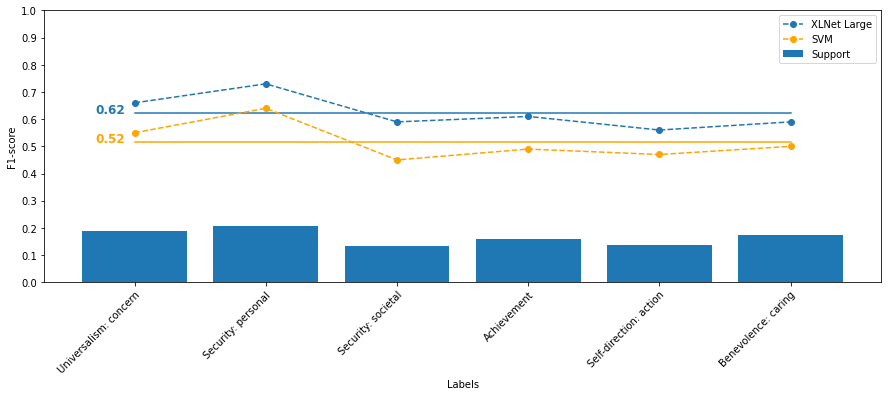

In [ ]:
PlotModelsF1({'XLNet Large':f1_results_xln, 'SVM':f1_results_svm}, target_names)

At first glance, it appears that the performance of the SVM is closer to that of XLNet-large: in fact, the macro F1-score of the SVM has increased by 22% compared to the previous task, while for the transformer model, the improvement is 13%. As we can see, the better results of the SVM are due to both a worse performance of XLNet-large and a better performance of the SVM for all classes except for "Benevolence: Caring". This indicates that both models are highly sensitive to the number of classes they are trained on and to their support. However, the previous considerations regarding tf-idf do not hold, as the majority of the most frequent words for each class also appear in the others. This highlights the absence of a specific vocabulary for these categories: instead, the high performance can be explained by the lower number of classes and the high support of each one, which makes the task easier for the two models.<br>
<br>
Then, we upload our "csv" with the all predictions.

In [ ]:
models_results = pd.read_csv('HVM_results_6-labels.csv')
models_results.head()

,Conclusion,Stance,Premise,labels,XLNetLargePredictions,SVMPredictions
0,Entrapment should be legalized,in favor of,if entrapment can serve to more easily capture...,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0]","[1.0, 0.0, 1.0, 0.0, 0.0, 0.0]","[0, 0, 1, 0, 1, 1]"
1,The use of public defenders should be mandatory,in favor of,the use of public defenders should be mandator...,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[1.0, 1.0, 1.0, 1.0, 0.0, 1.0]","[1, 1, 1, 1, 0, 1]"
2,Payday loans should be banned,in favor of,payday loans create a more impoverished societ...,"[1.0, 1.0, 0.0, 0.0, 0.0, 0.0]","[1.0, 1.0, 1.0, 0.0, 0.0, 0.0]","[1, 1, 1, 1, 0, 1]"
3,Surrogacy should be banned,against,Surrogacy should not be banned as it is the wo...,"[0.0, 0.0, 0.0, 0.0, 1.0, 0.0]","[1.0, 0.0, 0.0, 0.0, 1.0, 0.0]","[1, 0, 0, 0, 1, 1]"
4,Entrapment should be legalized,against,entrapment is gravely immoral and against huma...,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[1.0, 0.0, 0.0, 0.0, 0.0, 1.0]","[1, 0, 1, 1, 0, 1]"


In [ ]:
print('Labels:', ', '.join(target_names))

Labels: Universalism: concern, Security: personal, Security: societal, Achievement, Self-direction: action, Benevolence: caring


Now, let's see the TF-IDF for the class "Universalism:concern", which is the class with the second-highest F1-score.

In [ ]:
attribute = 'Universalism: concern'
pandas_results_most_frequency = PlotWordsDistribution(val, attribute, 100)
pandas_results_most_frequency.style.background_gradient(cmap='Greens', subset=pandas_results_most_frequency.columns[1:])

,ColumnName,people,blockade,gaza,criminal,strip,public,defender,banned,entrapment,good,use,ended,harm,offence,test,mandatory,intelligence,loan,holocaust,education,payday,legalized,suicide,denial,child,right,would,assisted,vocational,surrogacy,bring,foster,subsidize,crime,country,care,brings,need,european,eu,social,get,homeschooling,way,legal,help,one,someone,stop,non,medium,money,many,person,make,immigration,human,israel,government,poor,law,citizen,life,could,everyone,making,migration,year,murder,woman,interest,must,world,school,may,lawyer,society,able,better,system,family,often,europe,give,without,want,important,cause,financial,pay,illegal,resource,vow,celibacy,increase,national,marriage,language,high,student,commit,situation,even,state,lead,take,action,india,frontex,end,mean,time,allow,free,hamas,best,used,protect,others,well,environment,also,cannot,iq,problem,already,home,minimum,nuclear,put,income,necessary,know,go,low,therefore,wrong,much,area,allows,advantage,afford,group,thing,since,first,mass,age,kid,parent,job,unfair,standard,chance,case,really,nation,never,girl,control,voter,18,policy,energy,rate,based,innocent,living,economic,fair,abuse,suffering,form,violence,reason,like,ensure,peace,choice,otherwise,indian,reduce,immigrant,asylum,representation,type,result,different,become,happened,work,order,level,vulnerable,abandoned,number,common,climate,several,card,strengthen,border,getting,come,offense,committed,college,access,condition,sometimes,especially,terrorist,another,part,individual,lower,open,provide,defense,couple,etc,due,easy,instead,decision,keep,rule,humanity,proper,direct,health,change,21,hindi,value,tax,debt,stopped,act,community,deny,including,opportunity,certain,private,prey,punished,matter,trial,option,desperate,committing,force,happen,alternative,hurt,field,example,justice,rather,weapon,learning,lack,support,subsidy,homeopathy,process,nrc,aadhaar,caste,gas,migrant,waste,company,jewish,allowing,catch,might,hate,continue,taking,self,tool,enough,conviction,see,military,power,allowed,higher,prevent,possible,encourage,dangerous,possibility,sovereignty,security,medicine,ban,animal
0,Universalism: concern,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000151,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000115,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000101,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000086,0.000000,0.000000,0.000301,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000176,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000160,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000

We can see the same behaviour also for the two worst classes "Security: societal" and "Self-direction: action":

In [ ]:
attribute = 'Security: societal'
pandas_results_most_frequency = PlotWordsDistribution(val, attribute, 100)
pandas_results_most_frequency.style.background_gradient(cmap='Greens', subset=pandas_results_most_frequency.columns[1:])

,ColumnName,blockade,gaza,strip,ended,entrapment,people,criminal,legalized,offence,good,harm,holocaust,crime,brings,denial,suicide,social,education,country,medium,vocational,public,would,assisted,european,child,use,eu,defender,foster,banned,care,many,stop,need,immigration,right,legal,subsidize,mandatory,way,help,nuclear,migration,frontex,family,get,society,border,celibacy,israel,world,make,cause,illegal,vow,surrogacy,must,state,person,non,europe,television,immigrant,necessary,citizen,life,abandoned,migrant,year,problem,protect,commit,hamas,action,homeopathy,power,murder,woman,loan,mass,abandon,homeschooling,money,catch,lead,dangerous,may,control,used,someone,even,support,asylum,much,put,test,job,without,payday,one,time,resource,system,take,violence,otherwise,since,already,want,u,drug,energy,tool,law,well,environment,cannot,peace,better,know,intelligence,group,economic,area,government,terrorist,often,important,order,keep,safety,could,safe,allows,also,able,national,policy,value,first,unauthorized,sometimes,bring,parent,killing,including,free,situation,still,weapon,give,case,nation,allow,humanity,making,increase,financial,number,india,seeker,strengthen,thing,school,innocent,living,act,wrong,reason,work,idea,remove,become,continue,like,promote,card,pollution,reduce,direct,tax,reunification,home,mean,stopped,method,human,others,sex,whole,ensure,causing,condition,committing,happen,another,today,fact,happened,military,role,rule,prevent,organization,le,possible,bad,practice,political,end,several,member,improve,hand,nrc,voter,never,bullying,issue,think,useful,trade,trying,marriage,community,hurt,palestinian,individual,long,effect,mental,example,conviction,defense,pay,every,go,lack,committed,effective,towards,play,police,economy,sovereignty,security,caught,field,health,fake,given,etc,usa,bullet,caste,africa,coming,russian,wanted,death,activity,student,come,ending,region,subsidy,option,career,abuse,result,force,rocket,priest,civilian,terror,attack,lot,getting,rather,best,assisting,easy,allowed,going,lower,information,therefore,real,quality,matter,poor,everyone,level,street,hate,let,legalize,focus,really
0,Universalism: concern,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000035,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000116,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000012,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000026,0.000000,0.000000,0.000000,0.000000,0.000012,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000026,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000035,0.000000,0.000000,0.000035,0.000000,0.000000,0.000000,0.000000,0.000012,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000012,0.000000,0.000000,0.000000,0.000000,0.000129,0.000000,0.000000,0.000000,0.000000,0.000000,0

In [ ]:
attribute = 'Self-direction: action'
pandas_results_most_frequency = PlotWordsDistribution(val, attribute, 100)
pandas_results_most_frequency.style.background_gradient(cmap='Greens', subset=pandas_results_most_frequency.columns[1:])

,ColumnName,people,banned,criminal,good,offence,surrogacy,harm,vow,celibacy,right,education,suicide,homeschooling,child,public,assisted,brings,abandoned,vocational,use,defender,holocaust,homeopathy,denial,loan,payday,mandatory,social,medium,way,subsidize,need,many,able,want,one,person,blockade,gaza,strip,help,free,european,life,choice,non,parent,school,television,country,time,would,end,speech,make,someone,family,better,government,freedom,choose,couple,everyone,ended,may,without,entrapment,legal,get,medicine,suffering,give,test,allowed,allows,option,abandon,alternative,woman,stop,world,state,best,eu,crime,intelligence,society,care,pay,energy,bring,year,making,believe,citizen,decision,first,marriage,immigration,take,health,important,like,human,legalized,cannot,cause,job,offense,much,mean,pain,using,student,individual,law,become,home,well,otherwise,thing,change,age,language,work,allow,natural,form,must,continue,support,put,foster,drug,referendum,indian,girl,18,high,think,priest,suffer,others,sex,issue,surrogate,money,body,kid,medical,often,force,could,die,go,case,afford,instead,india,national,minimum,whether,sometimes,cost,provide,part,act,situation,provides,traditional,given,chance,even,really,system,away,homeopathic,effect,forced,therefore,saving,lawyer,etc,web,21,asylum,migration,wish,defense,find,mother,certain,personal,le,value,still,u,reason,proven,environment,due,used,unable,lead,opportunity,financial,feel,cattle,unauthorized,seeker,migrant,live,illegal,prevent,outdated,entertainment,offer,treatment,learning,trade,longer,condition,hope,never,matter,else,already,defend,skill,university,action,useful,real,problem,independent,common,anyone,decide,religious,living,keep,made,immigrant,0,increase,commission,legalize,pick,serious,safe,service,might,company,little,side,necessary,based,illness,career,path,potential,process,today,unfair,something,dangerous,bad,commit,thought,terminally,ill,church,activity,difficult,control,bullying,different,access,beneficial,effective,standard,religion,infertile,let,benefit,order,lot,terminal,humane,also,protected,higher,willing,violent,internet,nation,3,big,several,hindi
0,Universalism: concern,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000027,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000054,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000009,0.000000,0.000000,0.000000,0.000018,0.000000,0.000000,0.000009,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.

# Bibliography and sitography
- Original Paper for the Project: [Human Values Detection task for the SemEval 2023](https://touche.webis.de/semeval23/touche23-web/index.html)
- Link to Dataset: https://zenodo.org/record/7402070#.Y7VgzC9aZQJ
- XLNet-Large model: https://huggingface.co/xlnet-large-cased
- Reset Layers Weights: [On Stability of Few-Sample Transformer Fine-Tuning, CommonLit Readability Prize](https://www.kaggle.com/code/rhtsingh/on-stability-of-few-sample-transformer-fine-tuning)
- compute_metrics function: [Longformer Multilabel Text Classification, Jesus Leal ML](https://jesusleal.io/2021/04/21/Longformer-multilabel-classification/)

# GitHub Repository
You can find the PDF, the notebook and the report on: https://github.com/DitucSpa/Human-Values-Detection